## Classification experiment

This week we have 3 delivarables:
- A `.py` file that finds the best model's hyperparameters;
- The `.csv` file with best hyperparameters finded;
- A `.ipynb` file that shows the best hyperparameters finded and the final metrics for the text classification experiment.

This notebook aims to find the best model to compete against MultinomialNB and LogisticRegression - models selected by the professor. The data used here is available in the [Text Collections](https://github.com/ragero/text-collections/tree/master/complete_texts_csvs) Github repo. I chose an arbitrary dataset for this first experiment.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

### Data

In [3]:
df = pd.read_csv("text_databases/Dmoz-Sports.csv")
df

,file_name,text,class
0,3191005.txt,"Bryant Bulldogs Official site with news, sched...",Baseball
1,3193010.txt,Hirschbeck v. Alomar Covers a legal case betwe...,Baseball
2,3190744.txt,Mountaineers Baseball Official site. Includes ...,Baseball
3,3193695.txt,"M.S.H. Little League Contains news items, a li...",Baseball
4,3193486.txt,Quotations: Bob Uecker Baseball Almanac collec...,Baseball
...,...,...,...
13495,3274147.txt,"IMDb.com - Dwayne Johnson Filmography, awards,...",Wrestling
13496,3273536.txt,"Suwannee Wrestling Includes pictures, and stat...",Wrestling
13497,3274032.txt,"Jeff's Swanton Biography, facts and wallpapers.",Wrestling
13498,3274152.txt,Roddy Piper Tribute Includes background inform...,Wrestling


In [4]:
df.fillna('', inplace=True)
df

,file_name,text,class
0,3191005.txt,"Bryant Bulldogs Official site with news, sched...",Baseball
1,3193010.txt,Hirschbeck v. Alomar Covers a legal case betwe...,Baseball
2,3190744.txt,Mountaineers Baseball Official site. Includes ...,Baseball
3,3193695.txt,"M.S.H. Little League Contains news items, a li...",Baseball
4,3193486.txt,Quotations: Bob Uecker Baseball Almanac collec...,Baseball
...,...,...,...
13495,3274147.txt,"IMDb.com - Dwayne Johnson Filmography, awards,...",Wrestling
13496,3273536.txt,"Suwannee Wrestling Includes pictures, and stat...",Wrestling
13497,3274032.txt,"Jeff's Swanton Biography, facts and wallpapers.",Wrestling
13498,3274152.txt,Roddy Piper Tribute Includes background inform...,Wrestling


### Model exploration

I made some helper functions to quickly retrieve me a text classification experiment:
- In the folder `utils`, we have two functions:
    - `custom_cls`: fits a given model or pipeline and keeps track of performance metrics and elapsed time;
    - `get_cls_results`: a function that calls `custom_cls` and prints the metrics of the current using classification_report and a confusion matrix.

I also made some preprocessing transformers. All classes inherit from sklearn `TransformerMixin` and `BaseEstimator`. We have transformers for removing stopwords, for stemming, and also for lemmatization.

In [5]:
from preprocessing import StopwordsTransformer, StemmerTransformer, LemmatizerTransformer
from utils import get_cls_results

I usually choose a model for each 'category' of models:
- SVC is often a good baseline, both using the RBF and the linear kernels;
- A DecisionTree is also a good baseline for tree methods;
- Ensemble methods are also useful, so getting XGBoost or LightGBM is also a nice starting point;
- For linear methods, I generally took the LogisticRegression, but as this model is one the choices for the final experiment I got the RidgeClassifier instead.

To vectorize the text, I use the main Bag of Words methods available in sklearn:
- CountVectorizer
- TF-IDF
- HashingVectorizer

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import RidgeClassifier

In [7]:
# LGBM asks for float values, default of CountVectorizer is int64
cv_vec = CountVectorizer(dtype=np.float64)
tfidf_vec = TfidfVectorizer()
hash_vec = HashingVectorizer()

svc_model = SVC(random_state=14)
svc_linear_model = SVC(kernel='linear', max_iter=10000, random_state=14)
# lgbm talks a bit too much; verbose=-1 suppresses most of it
lgbm = LGBMClassifier(objective="multiclass", verbose=-1, random_state=14)
dt_model = DecisionTreeClassifier(random_state=14)
ridge = RidgeClassifier(random_state=14)

In [8]:
models_reprs = {
    'models': [svc_model, svc_linear_model, lgbm, dt_model, ridge],
    'vectorizers': [cv_vec, tfidf_vec, hash_vec]
}

The helper function `custom_cls`, called within the function `get_cls_results`, receives a dataframe like this one below to track the models' scores.

In [9]:
results = pd.DataFrame(columns=['Precision', 'Recall', 'F1-Score', 'Time elapsed'])

Split made according the given exercise instructions, using a 80-20 ratio for train and test data.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['class'],
                                                    test_size=0.2, random_state=14,
                                                    stratify=df['class'])

split_data = [X_train, X_test, y_train, y_test]

### Classification without preprocessing steps

In [11]:
from sklearn.pipeline import Pipeline
import time

SVC(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)


/home/user/unb/unb_mestrado/2_semestre/topicos_nlp/nlp/atividade_3/utils.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concat = pd.concat([results, row])


              precision    recall  f1-score   support

    Baseball       0.71      0.73      0.72       100
  Basketball       0.98      0.80      0.88       100
     Bowling       0.96      0.86      0.91       100
     Cricket       0.99      0.81      0.89       100
     Cycling       0.76      0.84      0.80       100
  Equestrian       0.83      0.76      0.79       100
     Fencing       0.98      0.89      0.93       100
      Flying       0.85      0.88      0.87       100
    Football       0.58      0.70      0.63       100
        Golf       0.97      0.93      0.95       100
  Gymnastics       1.00      0.86      0.92       100
      Hockey       0.74      0.70      0.72       100
    Lacrosse       1.00      0.96      0.98       100
     Martial       0.88      0.91      0.90       100
 Motorsports       0.68      0.75      0.71       100
   Paintball       0.83      0.87      0.85       100
     Running       0.99      0.90      0.94       100
     Skating       0.92    

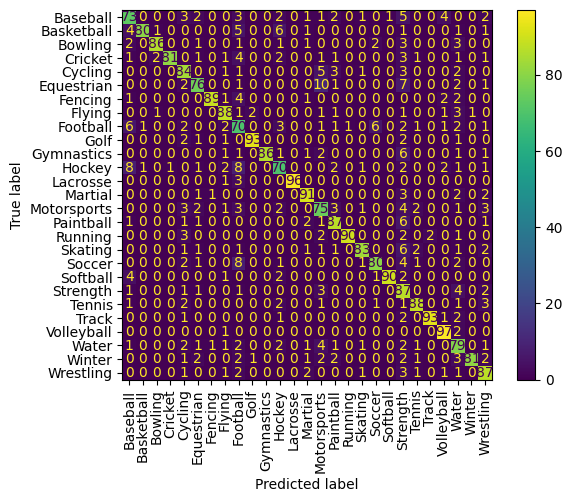

--- 19.6460177898407 seconds ---
SVC(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

    Baseball       0.84      0.81      0.83       100
  Basketball       0.99      0.82      0.90       100
     Bowling       0.97      0.94      0.95       100
     Cricket       0.99      0.86      0.92       100
     Cycling       0.83      0.90      0.87       100
  Equestrian       0.95      0.82      0.88       100
     Fencing       0.99      0.91      0.95       100
      Flying       0.91      0.92      0.92       100
    Football       0.70      0.83      0.76       100
        Golf       0.98      0.95      0.96       100
  Gymnastics       1.00      0.86      0.92       100
      Hockey       0.73      0.79      0.76       100
    Lacrosse       0.99      0.96      0.97       100
     Martial       0.93      0.98      0.96       100
 Motorsports       0.75      0.85      0.80       100
   Paintball       0.88      0.96      0.92       100
     Runn

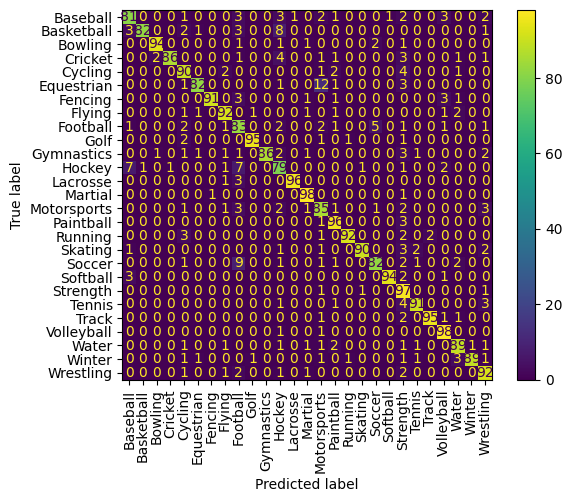

--- 25.192647218704224 seconds ---
SVC(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

    Baseball       0.76      0.77      0.77       100
  Basketball       0.98      0.79      0.87       100
     Bowling       0.97      0.88      0.92       100
     Cricket       0.99      0.84      0.91       100
     Cycling       0.81      0.85      0.83       100
  Equestrian       0.94      0.75      0.83       100
     Fencing       0.99      0.87      0.93       100
      Flying       0.86      0.89      0.87       100
    Football       0.60      0.72      0.65       100
        Golf       0.98      0.95      0.96       100
  Gymnastics       1.00      0.86      0.92       100
      Hockey       0.71      0.73      0.72       100
    Lacrosse       1.00      0.96      0.98       100
     Martial       0.87      0.94      0.90       100
 Motorsports       0.66      0.78      0.71       100
   Paintball       0.88      0.91      0.89       100
     

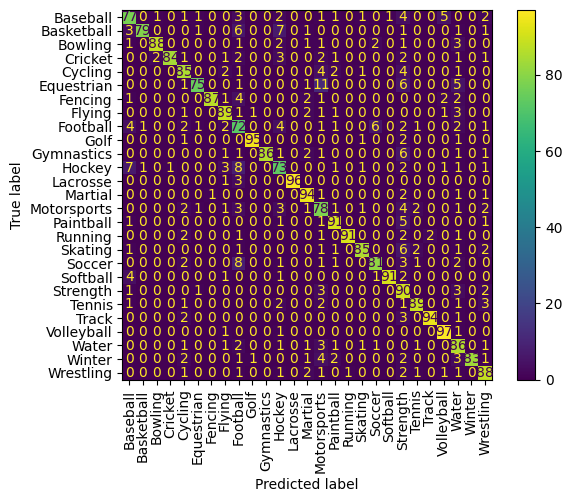

--- 19.22543454170227 seconds ---
SVC(kernel='linear', max_iter=10000, random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

    Baseball       0.75      0.78      0.76       100
  Basketball       0.86      0.83      0.85       100
     Bowling       0.95      0.90      0.92       100
     Cricket       0.84      0.86      0.85       100
     Cycling       0.83      0.86      0.84       100
  Equestrian       0.91      0.79      0.84       100
     Fencing       0.95      0.88      0.91       100
      Flying       0.81      0.87      0.84       100
    Football       0.66      0.69      0.68       100
        Golf       0.97      0.93      0.95       100
  Gymnastics       0.96      0.92      0.94       100
      Hockey       0.78      0.71      0.74       100
    Lacrosse       0.99      0.96      0.97       100
     Martial       0.90      0.93      0.92       100
 Motorsports       0.84      0.79      0.81       100


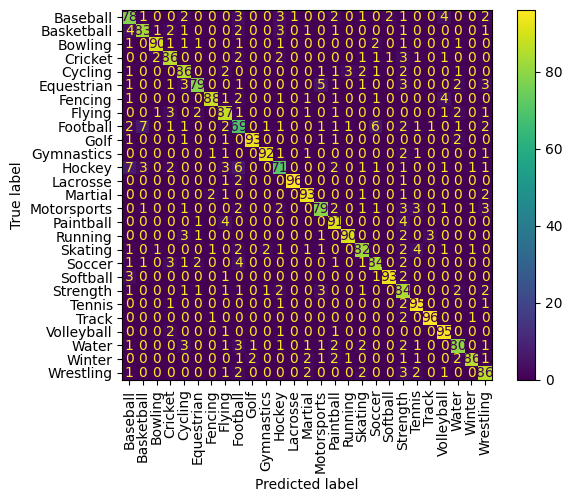

--- 10.210222005844116 seconds ---
SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

    Baseball       0.82      0.83      0.83       100
  Basketball       0.95      0.86      0.90       100
     Bowling       0.97      0.95      0.96       100
     Cricket       0.97      0.88      0.92       100
     Cycling       0.87      0.90      0.88       100
  Equestrian       0.95      0.84      0.89       100
     Fencing       0.99      0.93      0.96       100
      Flying       0.89      0.91      0.90       100
    Football       0.73      0.78      0.75       100
        Golf       0.97      0.96      0.96       100
  Gymnastics       1.00      0.90      0.95       100
      Hockey       0.76      0.79      0.77       100
    Lacrosse       1.00      0.96      0.98       100
     Martial       0.96      0.98      0.97       100
 Motorsports       0.78      0.85      0.81       100
   Paintball       0.88     

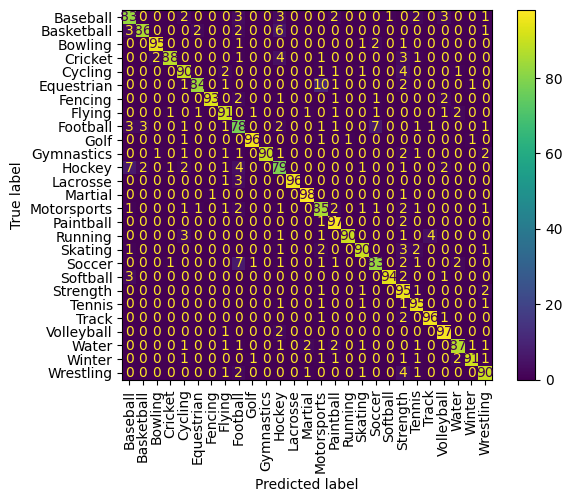

--- 14.64526081085205 seconds ---
SVC(kernel='linear', max_iter=10000, random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

    Baseball       0.77      0.78      0.78       100
  Basketball       0.94      0.81      0.87       100
     Bowling       0.96      0.91      0.93       100
     Cricket       0.98      0.85      0.91       100
     Cycling       0.80      0.87      0.83       100
  Equestrian       0.88      0.76      0.82       100
     Fencing       0.98      0.91      0.94       100
      Flying       0.85      0.92      0.88       100
    Football       0.66      0.74      0.70       100
        Golf       0.97      0.93      0.95       100
  Gymnastics       0.99      0.88      0.93       100
      Hockey       0.70      0.70      0.70       100
    Lacrosse       1.00      0.96      0.98       100
     Martial       0.93      0.96      0.95       100
 Motorsports       0.73      0.80      0.77       100
   Paintball       0.88    

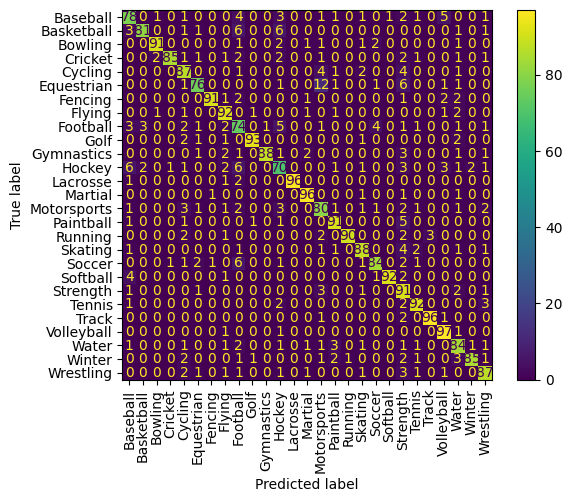

--- 13.726157188415527 seconds ---
LGBMClassifier(objective='multiclass', random_state=14, verbose=-1) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

    Baseball       0.71      0.75      0.73       100
  Basketball       0.88      0.81      0.84       100
     Bowling       0.97      0.90      0.93       100
     Cricket       0.90      0.82      0.86       100
     Cycling       0.86      0.83      0.84       100
  Equestrian       0.91      0.77      0.83       100
     Fencing       0.98      0.90      0.94       100
      Flying       0.88      0.87      0.87       100
    Football       0.63      0.66      0.64       100
        Golf       0.99      0.93      0.96       100
  Gymnastics       0.97      0.91      0.94       100
      Hockey       0.68      0.69      0.69       100
    Lacrosse       0.98      0.97      0.97       100
     Martial       0.90      0.90      0.90       100
 Motorsports       0.69      0.76      

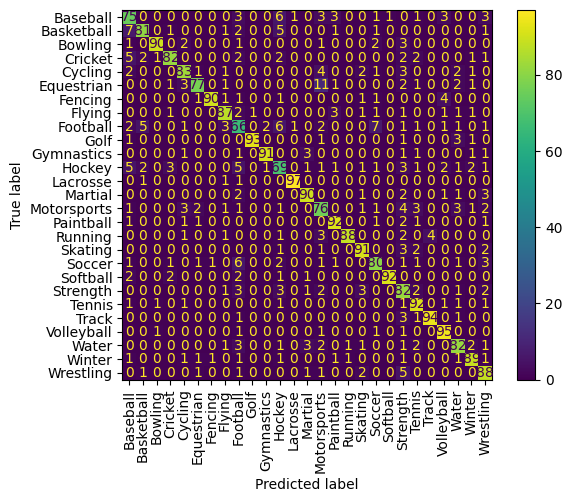

--- 4.992953062057495 seconds ---
LGBMClassifier(objective='multiclass', random_state=14, verbose=-1) TfidfVectorizer()
              precision    recall  f1-score   support

    Baseball       0.74      0.78      0.76       100
  Basketball       0.93      0.79      0.85       100
     Bowling       0.97      0.88      0.92       100
     Cricket       0.95      0.84      0.89       100
     Cycling       0.85      0.83      0.84       100
  Equestrian       0.88      0.80      0.84       100
     Fencing       0.99      0.84      0.91       100
      Flying       0.85      0.91      0.88       100
    Football       0.57      0.71      0.63       100
        Golf       0.97      0.93      0.95       100
  Gymnastics       0.98      0.88      0.93       100
      Hockey       0.65      0.72      0.69       100
    Lacrosse       0.98      0.97      0.97       100
     Martial       0.91      0.87      0.89       100
 Motorsports       0.65      0.74      0.69       100
   Paintball   

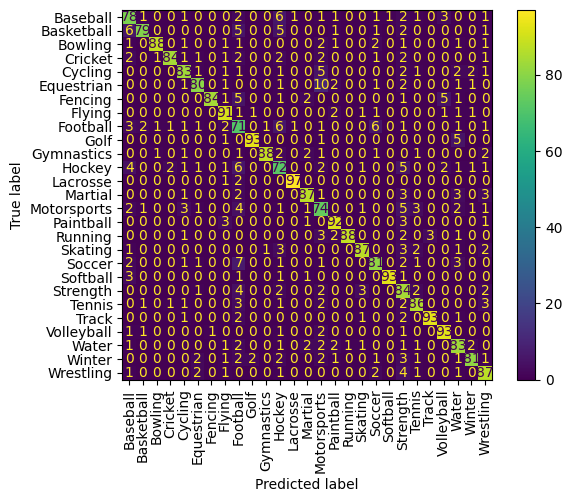

--- 14.211791038513184 seconds ---
LGBMClassifier(objective='multiclass', random_state=14, verbose=-1) HashingVectorizer()
              precision    recall  f1-score   support

    Baseball       0.69      0.79      0.74       100
  Basketball       0.95      0.79      0.86       100
     Bowling       0.98      0.89      0.93       100
     Cricket       0.97      0.83      0.89       100
     Cycling       0.89      0.83      0.86       100
  Equestrian       0.85      0.82      0.83       100
     Fencing       0.99      0.86      0.92       100
      Flying       0.85      0.88      0.86       100
    Football       0.64      0.71      0.67       100
        Golf       0.96      0.93      0.94       100
  Gymnastics       0.97      0.89      0.93       100
      Hockey       0.62      0.69      0.65       100
    Lacrosse       0.98      0.97      0.97       100
     Martial       0.89      0.88      0.88       100
 Motorsports       0.67      0.77      0.72       100
   Paintball

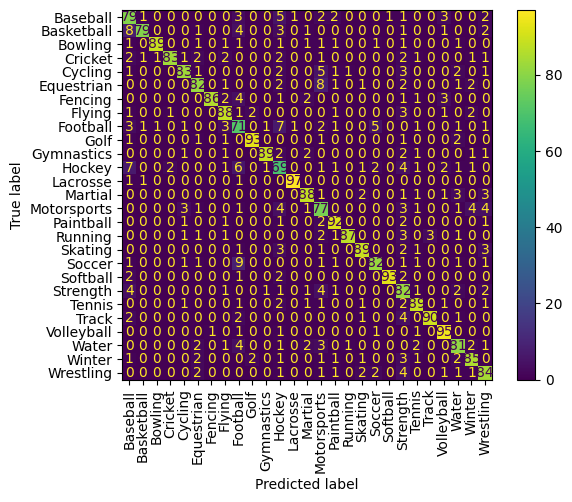

--- 12.833035945892334 seconds ---
DecisionTreeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

    Baseball       0.61      0.71      0.66       100
  Basketball       0.81      0.80      0.80       100
     Bowling       0.93      0.89      0.91       100
     Cricket       0.83      0.82      0.82       100
     Cycling       0.82      0.78      0.80       100
  Equestrian       0.89      0.71      0.79       100
     Fencing       0.86      0.87      0.87       100
      Flying       0.73      0.80      0.76       100
    Football       0.59      0.63      0.61       100
        Golf       0.92      0.92      0.92       100
  Gymnastics       0.83      0.87      0.85       100
      Hockey       0.73      0.61      0.66       100
    Lacrosse       0.95      0.96      0.96       100
     Martial       0.82      0.76      0.79       100
 Motorsports       0.58      0.60      0.59       100
   Paintball 

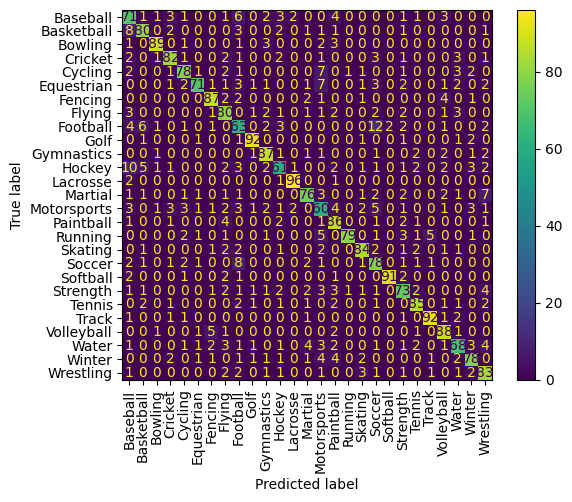

--- 1.5815157890319824 seconds ---
DecisionTreeClassifier(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

    Baseball       0.70      0.71      0.71       100
  Basketball       0.85      0.83      0.84       100
     Bowling       0.83      0.88      0.85       100
     Cricket       0.82      0.82      0.82       100
     Cycling       0.74      0.78      0.76       100
  Equestrian       0.81      0.68      0.74       100
     Fencing       0.91      0.84      0.88       100
      Flying       0.69      0.77      0.73       100
    Football       0.69      0.67      0.68       100
        Golf       0.93      0.92      0.92       100
  Gymnastics       0.91      0.86      0.89       100
      Hockey       0.67      0.61      0.64       100
    Lacrosse       0.94      0.95      0.95       100
     Martial       0.83      0.78      0.80       100
 Motorsports       0.55      0.56      0.56       100
   Paintball       0.76      0.87      0.8

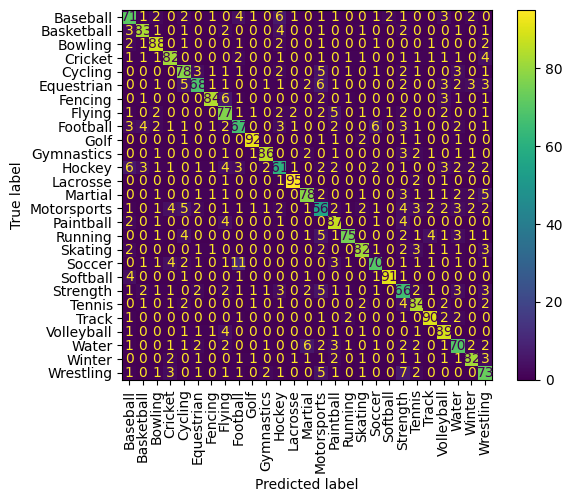

--- 2.150275707244873 seconds ---
DecisionTreeClassifier(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

    Baseball       0.66      0.71      0.69       100
  Basketball       0.88      0.80      0.84       100
     Bowling       0.84      0.86      0.85       100
     Cricket       0.83      0.81      0.82       100
     Cycling       0.69      0.76      0.72       100
  Equestrian       0.81      0.66      0.73       100
     Fencing       0.94      0.84      0.89       100
      Flying       0.78      0.80      0.79       100
    Football       0.65      0.61      0.63       100
        Golf       0.94      0.93      0.93       100
  Gymnastics       0.86      0.87      0.87       100
      Hockey       0.60      0.63      0.61       100
    Lacrosse       0.94      0.97      0.96       100
     Martial       0.80      0.77      0.79       100
 Motorsports       0.59      0.58      0.59       100
   Paintball       0.80      0.88      0.

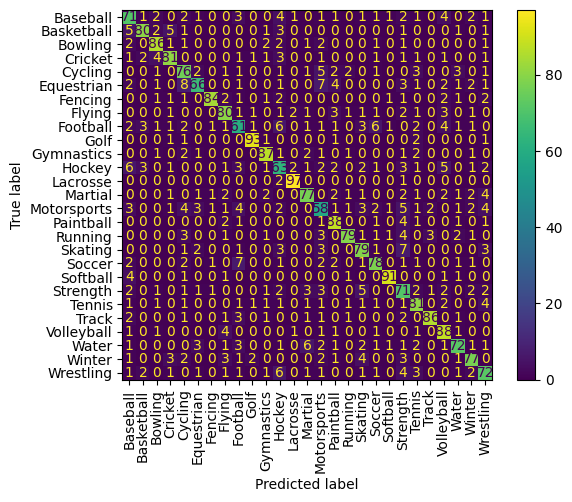

--- 18.92178249359131 seconds ---
RidgeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

    Baseball       0.75      0.80      0.78       100
  Basketball       0.84      0.88      0.86       100
     Bowling       0.93      0.93      0.93       100
     Cricket       0.94      0.87      0.90       100
     Cycling       0.88      0.88      0.88       100
  Equestrian       0.95      0.82      0.88       100
     Fencing       0.96      0.90      0.93       100
      Flying       0.75      0.89      0.82       100
    Football       0.72      0.73      0.73       100
        Golf       0.98      0.95      0.96       100
  Gymnastics       0.97      0.89      0.93       100
      Hockey       0.84      0.75      0.79       100
    Lacrosse       1.00      0.96      0.98       100
     Martial       0.99      0.94      0.96       100
 Motorsports       0.91      0.78      0.84       100
   Paintball       0.

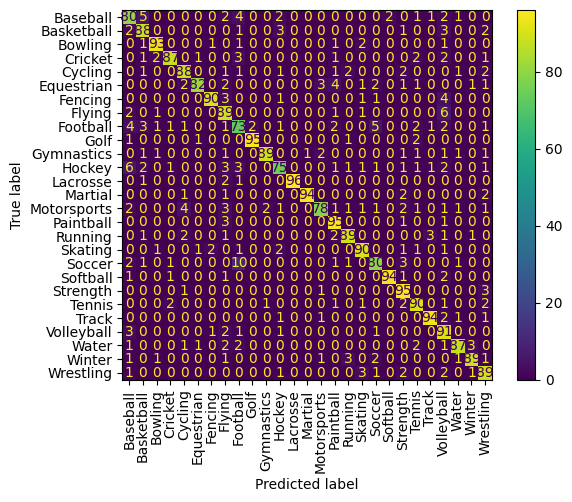

--- 10.182714700698853 seconds ---
RidgeClassifier(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

    Baseball       0.85      0.81      0.83       100
  Basketball       0.90      0.89      0.89       100
     Bowling       0.95      0.96      0.96       100
     Cricket       0.97      0.91      0.94       100
     Cycling       0.88      0.92      0.90       100
  Equestrian       0.97      0.85      0.90       100
     Fencing       0.97      0.92      0.94       100
      Flying       0.81      0.92      0.86       100
    Football       0.74      0.77      0.75       100
        Golf       0.98      0.98      0.98       100
  Gymnastics       0.98      0.93      0.95       100
      Hockey       0.82      0.80      0.81       100
    Lacrosse       0.99      0.96      0.97       100
     Martial       0.96      0.98      0.97       100
 Motorsports       0.87      0.82      0.85       100
   Paintball       0.90      0.98      0.94      

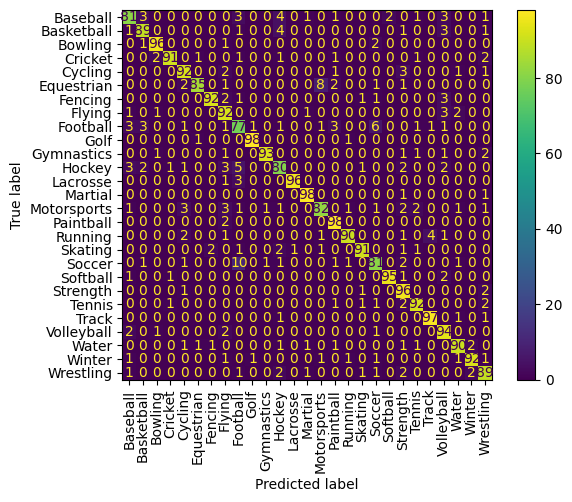

--- 2.751560926437378 seconds ---
RidgeClassifier(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

    Baseball       0.86      0.78      0.82       100
  Basketball       0.89      0.87      0.88       100
     Bowling       0.95      0.95      0.95       100
     Cricket       0.99      0.90      0.94       100
     Cycling       0.88      0.90      0.89       100
  Equestrian       0.98      0.83      0.90       100
     Fencing       1.00      0.91      0.95       100
      Flying       0.79      0.95      0.86       100
    Football       0.72      0.77      0.74       100
        Golf       0.99      0.98      0.98       100
  Gymnastics       0.97      0.91      0.94       100
      Hockey       0.84      0.75      0.79       100
    Lacrosse       1.00      0.96      0.98       100
     Martial       0.94      0.98      0.96       100
 Motorsports       0.85      0.82      0.83       100
   Paintball       0.90      0.97      0.93     

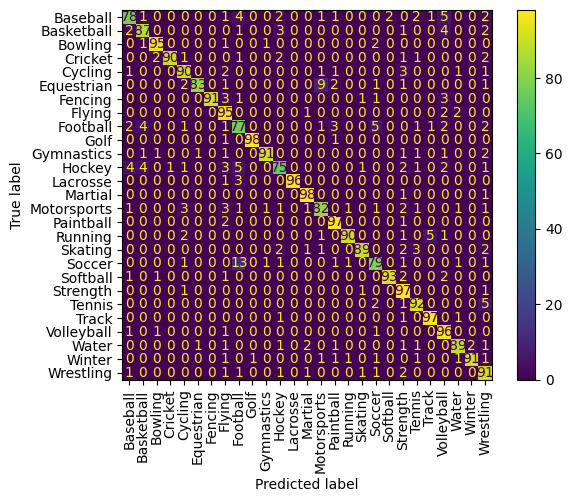

--- 14.816973209381104 seconds ---


In [12]:
for model in models_reprs['models']:
    for vect in models_reprs['vectorizers']:
        start_time = time.time()
        model_label = str(model) + ' ' + str(vect)
        print(model_label)
        pipe = Pipeline(steps=[
            ('feature_extraction', vect),
            ('model', model)
        ])
        results = get_cls_results(results, model_label, split_data, show_results=True, pipe=pipe)
        print("--- %s seconds ---" % (time.time() - start_time))

In [13]:
results

,Precision,Recall,F1-Score,Time elapsed
RidgeClassifier(random_state=14) TfidfVectorizer(),0.908691,0.906296,0.906571,1.977748
"SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()",0.907593,0.902593,0.903674,13.870199
SVC(random_state=14) TfidfVectorizer(),0.907764,0.898148,0.900164,24.553652
RidgeClassifier(random_state=14) HashingVectorizer(),0.903722,0.898889,0.899395,14.151965
RidgeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>),0.886579,0.881481,0.882319,9.315561
"SVC(kernel='linear', max_iter=10000, random_state=14) HashingVectorizer()",0.880937,0.872222,0.874315,13.028322
SVC(random_state=14) HashingVectorizer(),0.877226,0.860741,0.864928,18.586222
"SVC(kernel='linear', max_iter=10000, random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)",0.867940,0.863704,0.864560,9.639584
"LGBMClassifier(objective='multiclass', random_state=14, verbose=-1) CountVectorizer(dtype=<class 'numpy.float64'>)",0.862402,0.856296,0.858002,4.223895
"LGBMClassifier(objective='multiclass', random_state=14, verbose=-1) HashingVectorizer()",0.862949,0.852593,0.855729,12.143850


### Preprocessing experiment

Same experiment, but now with some combinations of preprocessing.

In [14]:
pre_processing_pipe_all = Pipeline(
    steps=[
        ("stopwords", StopwordsTransformer(languages=["en"])),
        ("lemmatizer", LemmatizerTransformer(language="en")),
        ("stemmer", StemmerTransformer(method="porter"))
    ]
)

pre_processing_pipe_stop_lemma = Pipeline(
    steps=[
        ("stopwords", StopwordsTransformer(languages=["en"])),
        ("lemmatizer", LemmatizerTransformer(language="en"))
    ]
)

pre_processing_pipe_stop_stem = Pipeline(
    steps=[
        ("stopwords", StopwordsTransformer(languages=["en"])),
        ("stemmer", StemmerTransformer(method="porter"))
    ]
)

pre_processing_pipe_stop_only = Pipeline(
    steps=[
        ("stopwords", StopwordsTransformer(languages=["en"]))
    ]
)

All Preprocs - SVC(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

    Baseball       0.79      0.70      0.74       100
  Basketball       0.94      0.80      0.86       100
     Bowling       0.95      0.87      0.91       100
     Cricket       0.99      0.83      0.90       100
     Cycling       0.89      0.87      0.88       100
  Equestrian       0.89      0.76      0.82       100
     Fencing       0.95      0.90      0.92       100
      Flying       0.87      0.92      0.89       100
    Football       0.59      0.75      0.66       100
        Golf       0.98      0.95      0.96       100
  Gymnastics       1.00      0.89      0.94       100
      Hockey       0.70      0.66      0.68       100
    Lacrosse       1.00      0.96      0.98       100
     Martial       0.90      0.91      0.91       100
 Motorsports       0.69      0.78      0.73       100
   Paintball       0.83      0.91      0.87       10

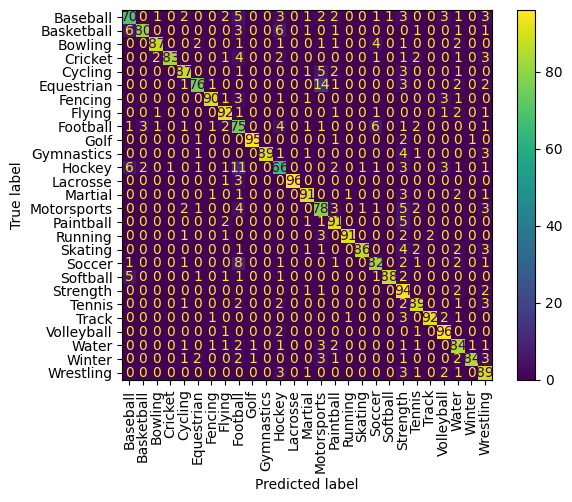

--- 19.70503044128418 seconds ---
All Preprocs - SVC(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

    Baseball       0.80      0.81      0.81       100
  Basketball       0.98      0.83      0.90       100
     Bowling       0.96      0.94      0.95       100
     Cricket       0.99      0.85      0.91       100
     Cycling       0.93      0.87      0.90       100
  Equestrian       0.96      0.82      0.89       100
     Fencing       1.00      0.91      0.95       100
      Flying       0.91      0.90      0.90       100
    Football       0.67      0.82      0.74       100
        Golf       0.98      0.96      0.97       100
  Gymnastics       0.99      0.90      0.94       100
      Hockey       0.72      0.77      0.74       100
    Lacrosse       1.00      0.96      0.98       100
     Martial       0.95      0.99      0.97       100
 Motorsports       0.75      0.87      0.81       100
   Paintball       0.92      0.96      0.94    

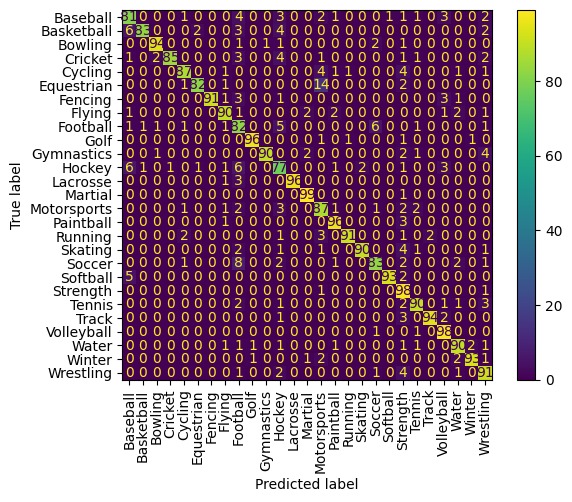

--- 24.019289016723633 seconds ---
All Preprocs - SVC(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

    Baseball       0.82      0.75      0.78       100
  Basketball       0.96      0.79      0.87       100
     Bowling       0.95      0.89      0.92       100
     Cricket       0.99      0.85      0.91       100
     Cycling       0.89      0.85      0.87       100
  Equestrian       0.96      0.78      0.86       100
     Fencing       0.99      0.89      0.94       100
      Flying       0.87      0.91      0.89       100
    Football       0.62      0.76      0.68       100
        Golf       0.98      0.96      0.97       100
  Gymnastics       1.00      0.89      0.94       100
      Hockey       0.68      0.71      0.70       100
    Lacrosse       1.00      0.96      0.98       100
     Martial       0.91      0.96      0.93       100
 Motorsports       0.68      0.82      0.74       100
   Paintball       0.90      0.95      0.92 

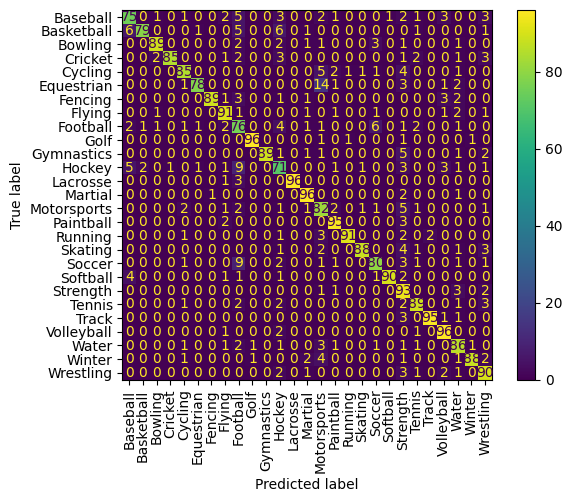

--- 19.485747575759888 seconds ---
All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

    Baseball       0.76      0.78      0.77       100
  Basketball       0.86      0.83      0.85       100
     Bowling       0.94      0.94      0.94       100
     Cricket       0.88      0.85      0.86       100
     Cycling       0.87      0.86      0.86       100
  Equestrian       1.00      0.80      0.89       100
     Fencing       0.93      0.87      0.90       100
      Flying       0.88      0.91      0.89       100
    Football       0.68      0.70      0.69       100
        Golf       0.97      0.96      0.96       100
  Gymnastics       0.95      0.93      0.94       100
      Hockey       0.76      0.69      0.72       100
    Lacrosse       0.97      0.97      0.97       100
     Martial       0.95      0.91      0.93       100
 Motorsports       0.79      0.81     

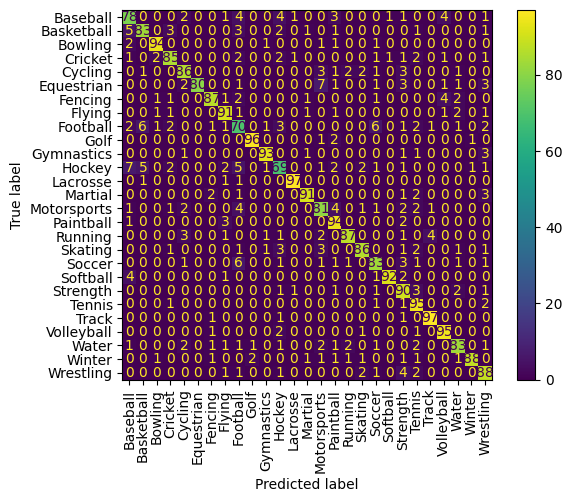

--- 11.520300388336182 seconds ---
All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

    Baseball       0.76      0.81      0.79       100
  Basketball       0.95      0.86      0.90       100
     Bowling       0.96      0.95      0.95       100
     Cricket       0.98      0.88      0.93       100
     Cycling       0.89      0.89      0.89       100
  Equestrian       0.99      0.84      0.91       100
     Fencing       0.97      0.92      0.94       100
      Flying       0.88      0.91      0.90       100
    Football       0.71      0.80      0.75       100
        Golf       0.98      0.97      0.97       100
  Gymnastics       0.98      0.93      0.95       100
      Hockey       0.78      0.77      0.77       100
    Lacrosse       1.00      0.96      0.98       100
     Martial       0.95      0.99      0.97       100
 Motorsports       0.80      0.83      0.81       100
   Paintball 

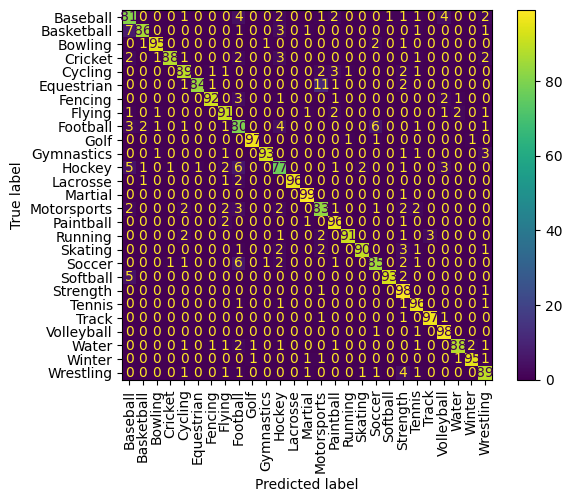

--- 15.026963233947754 seconds ---
All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

    Baseball       0.74      0.76      0.75       100
  Basketball       0.97      0.83      0.89       100
     Bowling       0.94      0.94      0.94       100
     Cricket       0.99      0.85      0.91       100
     Cycling       0.91      0.86      0.88       100
  Equestrian       0.94      0.80      0.86       100
     Fencing       0.94      0.90      0.92       100
      Flying       0.88      0.92      0.90       100
    Football       0.67      0.74      0.70       100
        Golf       0.97      0.96      0.96       100
  Gymnastics       0.99      0.90      0.94       100
      Hockey       0.75      0.73      0.74       100
    Lacrosse       1.00      0.96      0.98       100
     Martial       0.90      0.95      0.93       100
 Motorsports       0.74      0.81      0.77       100
   Paintbal

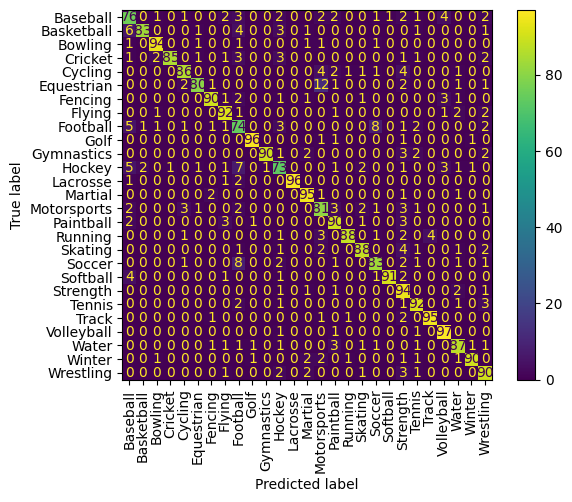

--- 12.85897707939148 seconds ---
All Preprocs - LGBMClassifier(objective='multiclass', random_state=14, verbose=-1) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

    Baseball       0.66      0.75      0.70       100
  Basketball       0.86      0.81      0.84       100
     Bowling       0.95      0.90      0.92       100
     Cricket       0.91      0.84      0.88       100
     Cycling       0.89      0.85      0.87       100
  Equestrian       0.89      0.87      0.88       100
     Fencing       0.99      0.89      0.94       100
      Flying       0.93      0.90      0.91       100
    Football       0.68      0.69      0.69       100
        Golf       0.97      0.94      0.95       100
  Gymnastics       0.98      0.93      0.95       100
      Hockey       0.66      0.71      0.69       100
    Lacrosse       0.99      0.97      0.98       100
     Martial       0.91      0.91      0.91       100
 Motorsports       0.80  

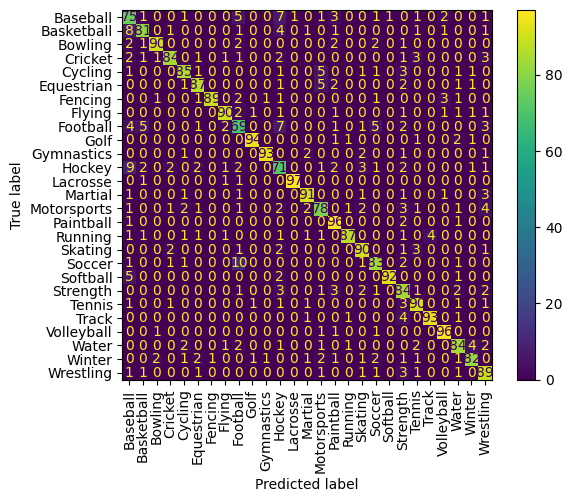

--- 7.548635244369507 seconds ---
All Preprocs - LGBMClassifier(objective='multiclass', random_state=14, verbose=-1) TfidfVectorizer()
              precision    recall  f1-score   support

    Baseball       0.80      0.74      0.77       100
  Basketball       0.90      0.81      0.85       100
     Bowling       0.97      0.88      0.92       100
     Cricket       0.96      0.82      0.89       100
     Cycling       0.86      0.83      0.84       100
  Equestrian       0.94      0.85      0.89       100
     Fencing       1.00      0.87      0.93       100
      Flying       0.90      0.88      0.89       100
    Football       0.60      0.74      0.66       100
        Golf       0.96      0.93      0.94       100
  Gymnastics       0.99      0.90      0.94       100
      Hockey       0.65      0.71      0.68       100
    Lacrosse       0.99      0.97      0.98       100
     Martial       0.90      0.91      0.91       100
 Motorsports       0.72      0.79      0.76       100


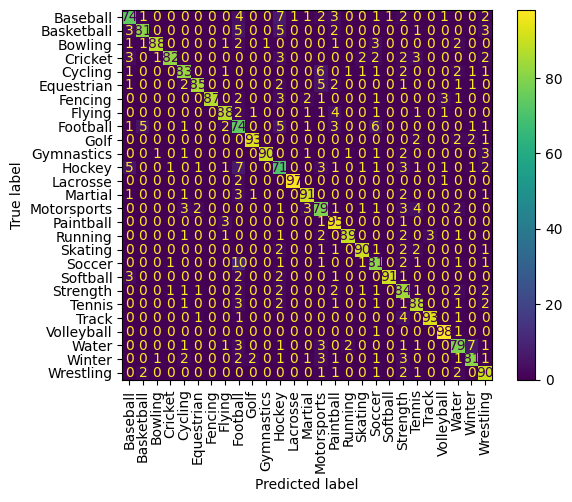

--- 15.652441501617432 seconds ---
All Preprocs - LGBMClassifier(objective='multiclass', random_state=14, verbose=-1) HashingVectorizer()
              precision    recall  f1-score   support

    Baseball       0.76      0.72      0.74       100
  Basketball       0.87      0.78      0.82       100
     Bowling       0.92      0.90      0.91       100
     Cricket       0.95      0.82      0.88       100
     Cycling       0.86      0.86      0.86       100
  Equestrian       0.95      0.86      0.90       100
     Fencing       0.99      0.89      0.94       100
      Flying       0.87      0.88      0.88       100
    Football       0.57      0.71      0.63       100
        Golf       0.96      0.94      0.95       100
  Gymnastics       0.98      0.91      0.94       100
      Hockey       0.58      0.69      0.63       100
    Lacrosse       0.98      0.96      0.97       100
     Martial       0.92      0.92      0.92       100
 Motorsports       0.77      0.77      0.77       1

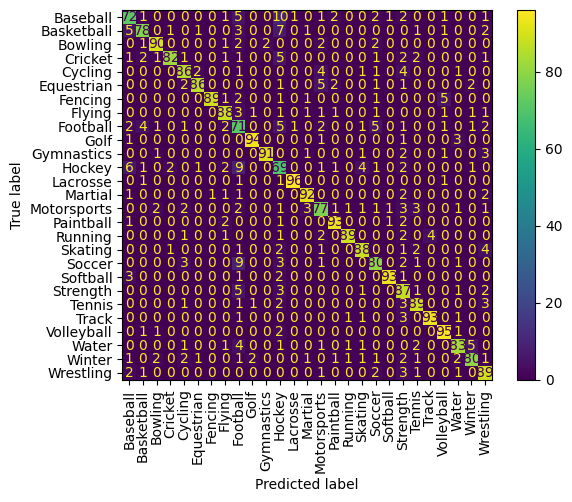

--- 14.482816457748413 seconds ---
All Preprocs - DecisionTreeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

    Baseball       0.69      0.68      0.69       100
  Basketball       0.84      0.81      0.82       100
     Bowling       0.89      0.86      0.87       100
     Cricket       0.89      0.86      0.87       100
     Cycling       0.88      0.83      0.86       100
  Equestrian       0.90      0.72      0.80       100
     Fencing       0.96      0.87      0.91       100
      Flying       0.78      0.75      0.77       100
    Football       0.53      0.66      0.59       100
        Golf       0.91      0.94      0.93       100
  Gymnastics       0.94      0.91      0.92       100
      Hockey       0.62      0.62      0.62       100
    Lacrosse       0.98      0.97      0.97       100
     Martial       0.82      0.81      0.81       100
 Motorsports       0.63      0.64      0.64       10

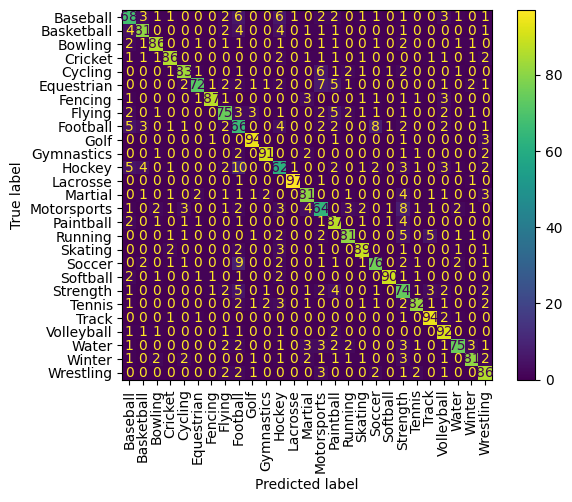

--- 4.288855314254761 seconds ---
All Preprocs - DecisionTreeClassifier(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

    Baseball       0.64      0.63      0.64       100
  Basketball       0.81      0.83      0.82       100
     Bowling       0.89      0.88      0.88       100
     Cricket       0.91      0.85      0.88       100
     Cycling       0.82      0.80      0.81       100
  Equestrian       0.88      0.70      0.78       100
     Fencing       0.84      0.86      0.85       100
      Flying       0.70      0.78      0.74       100
    Football       0.57      0.58      0.57       100
        Golf       0.94      0.91      0.92       100
  Gymnastics       0.87      0.90      0.88       100
      Hockey       0.62      0.66      0.64       100
    Lacrosse       0.94      0.97      0.96       100
     Martial       0.88      0.77      0.82       100
 Motorsports       0.54      0.61      0.58       100
   Paintball       0.79     

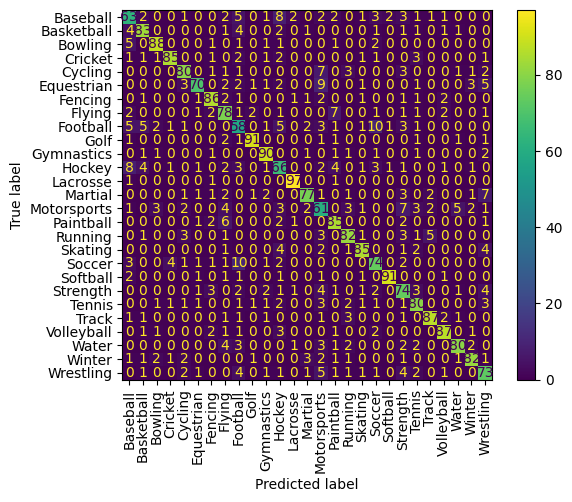

--- 4.651871919631958 seconds ---
All Preprocs - DecisionTreeClassifier(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

    Baseball       0.70      0.65      0.67       100
  Basketball       0.88      0.83      0.86       100
     Bowling       0.85      0.88      0.87       100
     Cricket       0.82      0.85      0.83       100
     Cycling       0.79      0.84      0.82       100
  Equestrian       0.91      0.73      0.81       100
     Fencing       0.90      0.86      0.88       100
      Flying       0.79      0.75      0.77       100
    Football       0.55      0.66      0.60       100
        Golf       0.90      0.94      0.92       100
  Gymnastics       0.97      0.90      0.93       100
      Hockey       0.63      0.60      0.62       100
    Lacrosse       0.94      0.95      0.95       100
     Martial       0.79      0.77      0.78       100
 Motorsports       0.61      0.65      0.63       100
   Paintball       0.77   

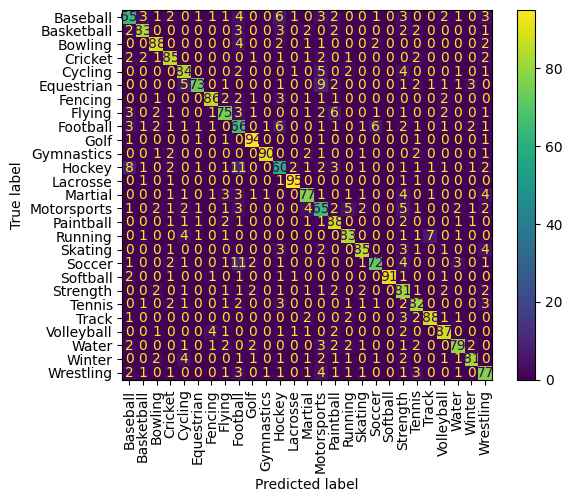

--- 20.708019256591797 seconds ---
All Preprocs - RidgeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>)
              precision    recall  f1-score   support

    Baseball       0.78      0.77      0.77       100
  Basketball       0.87      0.88      0.88       100
     Bowling       0.94      0.92      0.93       100
     Cricket       0.92      0.86      0.89       100
     Cycling       0.87      0.89      0.88       100
  Equestrian       0.94      0.84      0.89       100
     Fencing       0.94      0.91      0.92       100
      Flying       0.77      0.88      0.82       100
    Football       0.70      0.71      0.70       100
        Golf       0.96      0.95      0.95       100
  Gymnastics       0.93      0.91      0.92       100
      Hockey       0.78      0.73      0.75       100
    Lacrosse       1.00      0.96      0.98       100
     Martial       0.99      0.94      0.96       100
 Motorsports       0.90      0.75      0.82       100
   Pa

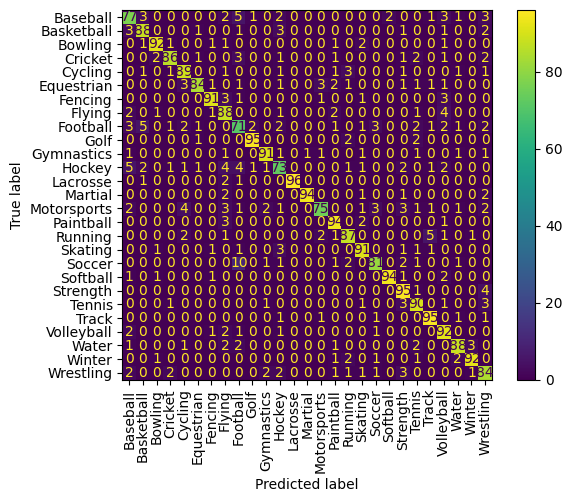

--- 12.675015687942505 seconds ---
All Preprocs - RidgeClassifier(random_state=14) TfidfVectorizer()
              precision    recall  f1-score   support

    Baseball       0.81      0.79      0.80       100
  Basketball       0.87      0.88      0.88       100
     Bowling       0.94      0.95      0.95       100
     Cricket       0.98      0.90      0.94       100
     Cycling       0.91      0.91      0.91       100
  Equestrian       0.97      0.87      0.92       100
     Fencing       0.97      0.91      0.94       100
      Flying       0.80      0.90      0.85       100
    Football       0.74      0.74      0.74       100
        Golf       0.98      0.98      0.98       100
  Gymnastics       0.95      0.92      0.93       100
      Hockey       0.80      0.77      0.79       100
    Lacrosse       0.98      0.96      0.97       100
     Martial       0.96      0.99      0.98       100
 Motorsports       0.89      0.85      0.87       100
   Paintball       0.90      0.94 

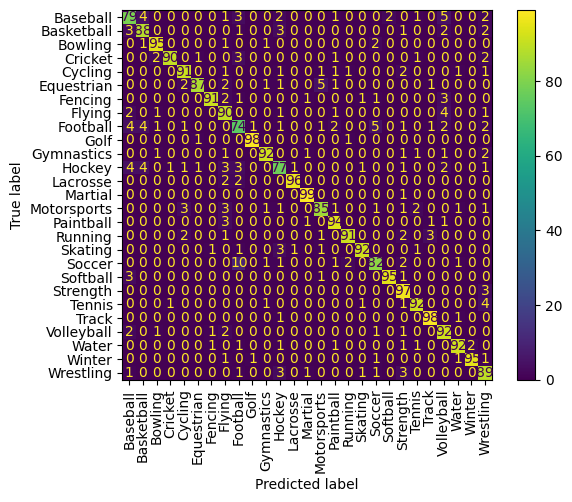

--- 5.3598082065582275 seconds ---
All Preprocs - RidgeClassifier(random_state=14) HashingVectorizer()
              precision    recall  f1-score   support

    Baseball       0.82      0.79      0.81       100
  Basketball       0.89      0.90      0.90       100
     Bowling       0.95      0.95      0.95       100
     Cricket       0.99      0.88      0.93       100
     Cycling       0.88      0.88      0.88       100
  Equestrian       0.99      0.86      0.92       100
     Fencing       0.99      0.90      0.94       100
      Flying       0.82      0.92      0.87       100
    Football       0.72      0.77      0.74       100
        Golf       0.98      0.97      0.97       100
  Gymnastics       0.97      0.91      0.94       100
      Hockey       0.81      0.76      0.78       100
    Lacrosse       0.99      0.96      0.97       100
     Martial       0.94      0.98      0.96       100
 Motorsports       0.85      0.83      0.84       100
   Paintball       0.90      0.9

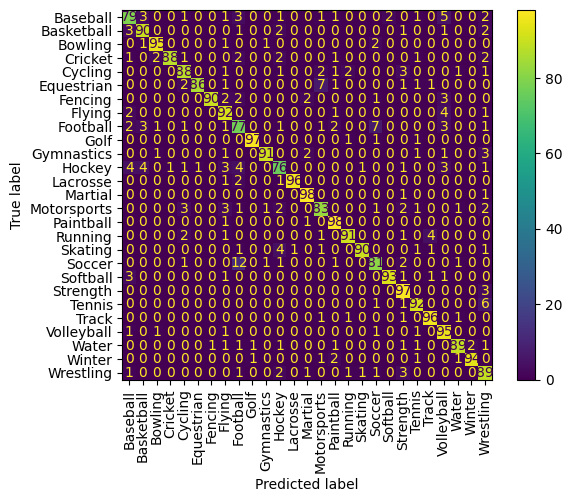

--- 16.878199815750122 seconds ---


In [15]:
for model in models_reprs['models']:
    for vect in models_reprs['vectorizers']:
        start_time = time.time()
        model_label = 'All Preprocs - ' + str(model) + ' ' + str(vect)
        print(model_label)
        pipe = Pipeline(steps=[('preprocessamento', pre_processing_pipe_all),
                               ('vectorizer', vect),
                               ('model', model)])
        results = get_cls_results(results, model_label, split_data, show_results=True, pipe=pipe)
        print("--- %s seconds ---" % (time.time() - start_time))

In [16]:
results

,Precision,Recall,F1-Score,Time elapsed
"All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()",0.910814,0.906296,0.907177,14.300320
RidgeClassifier(random_state=14) TfidfVectorizer(),0.908691,0.906296,0.906571,1.977748
All Preprocs - RidgeClassifier(random_state=14) TfidfVectorizer(),0.906451,0.904074,0.904409,4.530209
"SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()",0.907593,0.902593,0.903674,13.870199
All Preprocs - RidgeClassifier(random_state=14) HashingVectorizer(),0.904334,0.900370,0.900991,16.140133
All Preprocs - SVC(random_state=14) TfidfVectorizer(),0.907880,0.898889,0.900918,23.323116
SVC(random_state=14) TfidfVectorizer(),0.907764,0.898148,0.900164,24.553652
RidgeClassifier(random_state=14) HashingVectorizer(),0.903722,0.898889,0.899395,14.151965
RidgeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>),0.886579,0.881481,0.882319,9.315561
"All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) HashingVectorizer()",0.886777,0.880000,0.881470,12.157468


We have a new leader! Let's compute the other compositions of preprocessing pipelines to discover the winner.

In [17]:
for model in models_reprs['models']:
    for vect in models_reprs['vectorizers']:
        start_time = time.time()
        model_label = 'Stopwords and Lemmatization - ' + str(model) + ' ' + str(vect)
        # print(model_label)
        pipe = Pipeline(steps=[('preprocessamento', pre_processing_pipe_stop_lemma),
                               ('vectorizer', vect),
                               ('model', model)])
        # for the sake of the reader, here we'll only show the result dataframe
        results = get_cls_results(results, model_label, split_data, show_results=False, pipe=pipe)
        # print("--- %s seconds ---" % (time.time() - start_time))

In [18]:
for model in models_reprs['models']:
    for vect in models_reprs['vectorizers']:
        start_time = time.time()
        model_label = 'Stopwords and Stemmer - ' + str(model) + ' ' + str(vect)
        # print(model_label)
        pipe = Pipeline(steps=[('preprocessamento', pre_processing_pipe_stop_stem),
                               ('vectorizer', vect),
                               ('model', model)])
        # for the sake of the reader, here we'll only show the result dataframe
        results = get_cls_results(results, model_label, split_data, show_results=False, pipe=pipe)
        # print("--- %s seconds ---" % (time.time() - start_time))

In [19]:
for model in models_reprs['models']:
    for vect in models_reprs['vectorizers']:
        start_time = time.time()
        model_label = 'Only Stopwords - ' + str(model) + ' ' + str(vect)
        # print(model_label)
        pipe = Pipeline(steps=[('preprocessamento', pre_processing_pipe_stop_only),
                               ('vectorizer', vect),
                               ('model', model)])
        # for the sake of the reader, here we'll only show the result dataframe
        results = get_cls_results(results, model_label, split_data, show_results=False, pipe=pipe)
        # print("--- %s seconds ---" % (time.time() - start_time))

In [20]:
results

,Precision,Recall,F1-Score,Time elapsed
"Stopwords and Stemmer - SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()",0.912104,0.907407,0.908318,15.016262
"All Preprocs - SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()",0.910814,0.906296,0.907177,14.300320
RidgeClassifier(random_state=14) TfidfVectorizer(),0.908691,0.906296,0.906571,1.977748
"Stopwords and Lemmatization - SVC(kernel='linear', max_iter=10000, random_state=14) TfidfVectorizer()",0.909625,0.904444,0.905439,12.482594
All Preprocs - RidgeClassifier(random_state=14) TfidfVectorizer(),0.906451,0.904074,0.904409,4.530209
...,...,...,...,...
DecisionTreeClassifier(random_state=14) CountVectorizer(dtype=<class 'numpy.float64'>),0.804704,0.799259,0.800135,0.970256
All Preprocs - DecisionTreeClassifier(random_state=14) TfidfVectorizer(),0.802748,0.797407,0.798985,3.995714
Stopwords and Stemmer - DecisionTreeClassifier(random_state=14) TfidfVectorizer(),0.800376,0.796667,0.797173,3.983406
DecisionTreeClassifier(random_state=14) TfidfVectorizer(),0.791289,0.787037,0.787676,1.494756


Our top scorer here was a Linear SVM with stopwords and stemmer; if we consider the time elapsed as well, the Ridge Classifier without any preprocessing is the best choice.